In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train_dir = "/content/drive/MyDrive/dataset/train"
valid_dir = "/content/drive/MyDrive/dataset/valid"
test_dir = "/content/drive/MyDrive/dataset/test"

In [10]:
import pandas as pd
from PIL import Image
import os

MAIN_DIR = "/content/drive/MyDrive/dataset"

data = []
for split in ["train", "valid", "test"]:
    for dirname, _, filenames in os.walk(f'{MAIN_DIR}/{split}/'):
        if len(filenames) > 0:
            target = dirname.split("/")[-1]
            if "_" in target:
                target = target.split("_")[0]
            data.append({"files": filenames, "target": target, "split": split, "folder": dirname.split("/")[-1] })
df = pd.DataFrame(data)
df = df.explode("files")
df["path"] = df["split"] + "/" + df["folder"] + "/" + df["files"]
for index, row in df.iterrows():
    with Image.open(f"{MAIN_DIR}/{row.path}") as image:
        height, width = image.size
        df.loc[index, "height"] = height
        df.loc[index, "width"] = width
df = df.reset_index(drop=True)
df

,files,target,split,folder,path,height,width
0,10 - Copy (2).png,normal,train,normal,train/normal/10 - Copy (2).png,400.0,358.0
1,11 (2) - Copy.png,normal,train,normal,train/normal/11 (2) - Copy.png,400.0,358.0
2,11 - Copy (2).png,normal,train,normal,train/normal/11 - Copy (2).png,400.0,358.0
3,12 (2).png,normal,train,normal,train/normal/12 (2).png,400.0,358.0
4,12 - Copy (2) - Copy.png,normal,train,normal,train/normal/12 - Copy (2) - Copy.png,400.0,358.0
...,...,...,...,...,...,...,...
995,000162 (2).png,squamous.cell.carcinoma,test,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,test/squamous.cell.carcinoma_left.hilum_T1_N2_...,369.0,313.0
996,000134 (5).png,squamous.cell.carcinoma,test,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,test/squamous.cell.carcinoma_left.hilum_T1_N2_...,369.0,313.0
997,000163 (5).png,squamous.cell.carcinoma,test,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,test/squamous.cell.carcinoma_left.hilum_T1_N2_...,369.0,313.0
998,000139 (5).png,squamous.cell.carcinoma,test,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,test/squamous.cell.carcinoma_left.hilum_T1_N2_...,369.0,313.0


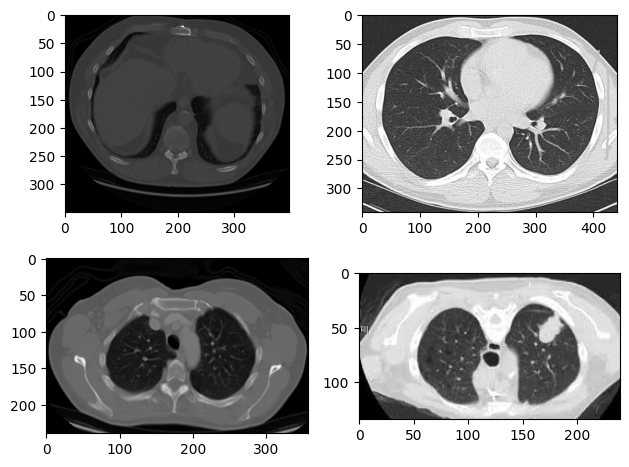

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read Images
sample = df.sample(4)
for i in range(4):
    plt.subplot(2, 2, i+1)
    img = mpimg.imread(f'{MAIN_DIR}/{sample.iloc[i].path}')
    plt.imshow(img)
plt.tight_layout()
plt.show()

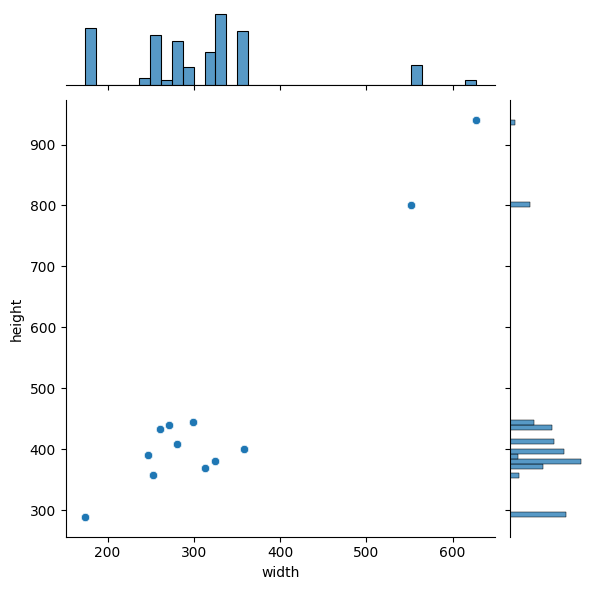

In [12]:
import seaborn as sns

sns.jointplot(df, x="width", y="height")
plt.show()

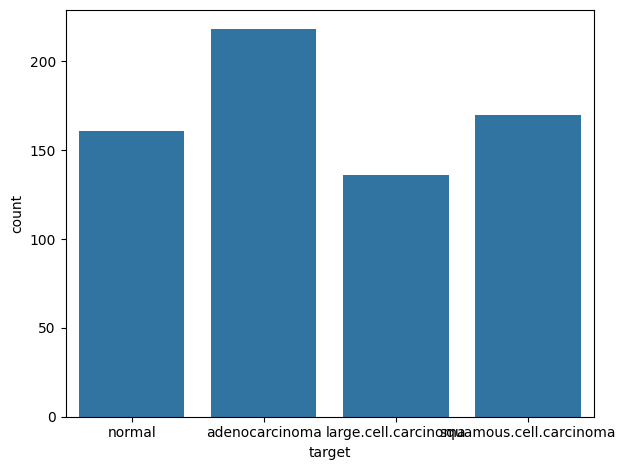

In [13]:
sns.countplot(df[(df["split"] == "train") | (df["split"] == "valid")], x="target")
plt.tight_layout()
plt.show()

In [14]:
from keras.applications import InceptionResNetV2
from keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input, layers, Model, metrics, optimizers, losses, callbacks
import tensorflow as tf
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [15]:
input_model = Input(shape= (256, 256, 3))
inception_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=input_model)
inception_model.trainable=False

x = layers.GlobalAveragePooling2D()(inception_model.output)
x = layers.Dropout(0.25)(x)
x = layers.Dense(4, activation="softmax", trainable=True)(x)
model = Model(inception_model.input, x)
model.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(label_smoothing=0.1),
            metrics=[CategoricalAccuracy(), Precision(), Recall(), AUC()])
model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

In [16]:
generator = ImageDataGenerator  (rescale = 1./255)

train_generator = generator.flow_from_dataframe(df[df.split == "train"], directory=MAIN_DIR,
    x_col='path', y_col='target', target_size = (256, 256), batch_size=32,
    class_mode='categorical')

val_generator = generator.flow_from_dataframe(df[df.split == "valid"], directory=MAIN_DIR,
    x_col='path', y_col='target', target_size = (256, 256), batch_size=32,
    class_mode='categorical')
test_generator = generator.flow_from_dataframe(df[df.split == "test"], directory=MAIN_DIR,
    x_col='path', y_col='target', target_size = (256, 256), batch_size=32,
    class_mode='categorical')

Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


In [17]:
learning_rate = 0.1
epochs = 20
decay_rate = 0.2
def scheduler(epoch):
    new_lr =  learning_rate * np.exp(-decay_rate * epoch)
    if new_lr > 0.001:
        return new_lr
    return 0.001
callbacks_list = [
    callbacks.EarlyStopping(monitor = "val_loss", patience = 5),
    callbacks.ModelCheckpoint(filepath="LCD.h5", monitor="val_loss", verbose=1, save_best_only=True),
    callbacks.LearningRateScheduler(scheduler)
]

In [19]:
import numpy as np

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = callbacks_list)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 12.0682 - categorical_accuracy: 0.3312 - precision: 0.3311 - recall: 0.3246 - auc: 0.5579 
Epoch 1: val_loss improved from inf to 3.03963, saving model to LCD.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 320s 15s/step - loss: 12.0682 - categorical_accuracy: 0.3312 - precision: 0.3311 - recall: 0.3246 - auc: 0.5579 - val_loss: 3.0396 - val_categorical_accuracy: 0.4722 - val_precision: 0.4789 - val_recall: 0.4722 - val_auc: 0.7063 - lr: 0.1000
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 3.1906 - categorical_accuracy: 0.5041 - precision: 0.5041 - recall: 0.5008 - auc: 0.7004 
Epoch 2: val_loss did not improve from 3.03963
20/20 [==============================] - 293s 15s/step - loss: 3.1906 - categorical_accuracy: 0.5041 - precision: 0.5041 - recall: 0.5008 - auc: 0.7004 - val_loss: 3.3120 - val_categorical_accuracy: 0.5694 - val_precision: 0.5694 - val_recall: 0.5694 - val_auc: 0.7380 - lr: 0.0819
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.7252 - categorical_accuracy: 0.6770 - precision: 0.6770 - recall: 0.6770 - auc: 0.8459 
Epoch 3: val_loss improved from 3.03963 to 1.60282, saving model to LCD.

In [20]:
metrics = model.evaluate(test_generator)
pd.DataFrame([metrics], columns=["loss", "Accuracy", "Precision", "Recall", "AUC"])

10/10 [==============================] - 126s 12s/step - loss: 0.5488 - categorical_accuracy: 0.6857 - precision: 0.7000 - recall: 0.6667 - auc: 0.8912


,loss,Accuracy,Precision,Recall,AUC
0,0.548798,0.685714,0.7,0.666667,0.891225


In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('LCD.h5')

# Save the model using pickle
with open('LCD_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as pickle file: LCD_model.pkl")

1/1 [==============================] - 7s 7s/step
The image belongs to class: non-cancerous


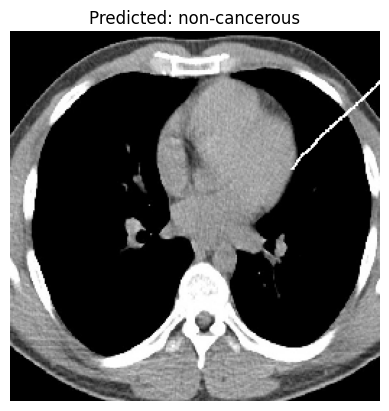

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['squamous cell carcinoma', 'large cell carcinoma', 'normal', 'adenocarcinoma']

# Function to load and preprocess an image for prediction
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Function to make a prediction
def predict_cell_class(img_path):
    # Preprocess the image
    img = load_and_preprocess_image(img_path, (256, 256))  # Adjusted image size

    # Make a prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])

    # Get the class label
    predicted_label = class_labels[predicted_class]

    # Determine if the cell is cancerous or non-cancerous
    if predicted_label == 'normal':
        cancerous_label = 'non-cancerous'
    else:
        cancerous_label = 'cancerous'

    # Print the predicted class and cancerous label
    print(f"The image belongs to class: {cancerous_label}")

    # Display the image with the predicted class and cancerous label
    plt.imshow(image.load_img(img_path, target_size=(256, 256)))  # Adjusted image size
    plt.title(f"Predicted: {cancerous_label}")
    plt.axis('off')
    plt.show()

# Path to the image you want to predict
img_path = '/content/drive/MyDrive/dataset/test/normal/12 - Copy (2) - Copy.png'

# Predict the class of the provided cell
predict_cell_class(img_path)


1/1 [==============================] - 1s 1s/step
The image belongs to class: cancerous


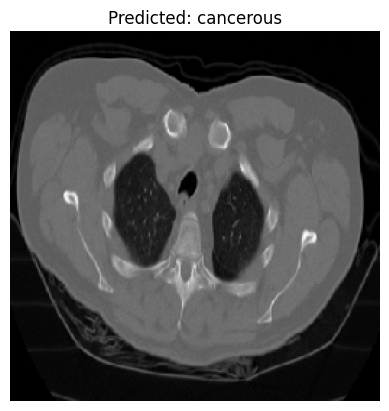

In [24]:


from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['squamous cell carcinoma', 'large cell carcinoma', 'normal', 'adenocarcinoma']

# Function to load and preprocess an image for prediction
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Function to make a prediction
def predict_cell_class(img_path):
    # Preprocess the image
    img = load_and_preprocess_image(img_path, (256, 256))  # Adjusted image size

    # Make a prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])

    # Get the class label
    predicted_label = class_labels[predicted_class]

    # Determine if the cell is cancerous or non-cancerous
    if predicted_label == 'normal':
        cancerous_label = 'non-cancerous'
    else:
        cancerous_label = 'cancerous'

    # Print the predicted class and cancerous label
    print(f"The image belongs to class: {cancerous_label}")

    # Display the image with the predicted class and cancerous label
    plt.imshow(image.load_img(img_path, target_size=(256, 256)))  # Adjusted image size
    plt.title(f"Predicted: {cancerous_label}")
    plt.axis('off')
    plt.show()

# Path to the image you want to predict
img_path = '/content/drive/MyDrive/dataset/test/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (3).png'

# Predict the class of the provided cell
predict_cell_class(img_path)